In [3]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import DL_project_utils as utils
import dlc_practical_prologue as prologue

%load_ext autoreload
%autoreload 1
%aimport DL_project_utils

In [16]:
class ResNetBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size,
                 skip_connections = True, batch_normalization = True, dropout=0):
        super().__init__()

        self.conv1 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn1 = nn.BatchNorm2d(nb_channels)

        self.conv2 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn2 = nn.BatchNorm2d(nb_channels)
        self.dropout = dropout

        self.skip_connections = skip_connections
        self.batch_normalization = batch_normalization

    def forward(self, x):
        y = F.dropout2d(x, self.dropout)
        y = self.conv1(y)
        if self.batch_normalization: y = self.bn1(y)
        y = F.relu(y)
        y = self.conv2(y)
        y = F.dropout2d(y, self.dropout)
        if self.batch_normalization: y = self.bn2(y)
        if self.skip_connections: y = y + x
        y = F.relu(y)
        

        return y

In [9]:
class ResNet(nn.Module):

    def __init__(self, nb_residual_blocks, nb_channels,
                 kernel_size, nb_classes = 10, nb_pred = 2,
                 skip_connections = True, batch_normalization = True, 
                 auxiliary_loss=False, auxiliary_weight=0.4):
        super().__init__()

        self.conv = nn.Conv2d(2, nb_channels,
                              kernel_size = kernel_size,
                              padding = (kernel_size - 1) // 2)
        self.bn = nn.BatchNorm2d(nb_channels)

        self.resnet_blocks = nn.Sequential(
            *(ResNetBlock(nb_channels, kernel_size, skip_connections, batch_normalization)
              for _ in range(nb_residual_blocks))
        )

        self.auxiliary_loss = auxiliary_loss
        self.auxiliary_weight = auxiliary_weight
        if auxiliary_loss:
            self.fc1 = nn.Linear(nb_channels, nb_classes * nb_pred)
            self.fc2 = nn.Linear(nb_classes * nb_pred, nb_pred)
        else:
            self.fc = nn.Linear(nb_channels, nb_pred)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.resnet_blocks(x)
        x = F.avg_pool2d(x, 14).view(x.size(0), -1)
        if self.auxiliary_loss:
            x = self.fc1(x)
            classes = x.view(-1, 10, 2)
            x = F.relu(x)
            x = self.fc2(x)
            return x, classes
        else:
            x = self.fc(x)
            return x

 # with auxiliary loss

In [10]:
train_data, test_data = utils.read_input(normalize=True, pairs=1000, verbose=True)
epochs, lr, loss, optimizer, batch_size = 45, 0.01, 'cross_entropy', 'SGD', 20
model = ResNet(nb_residual_blocks = 10, nb_channels = 10, kernel_size = 5, 
               nb_classes = 10, nb_pred = 2,
               auxiliary_loss=True, auxiliary_weight=0.4)
train_loss, train_acc, val_loss, val_acc = utils.train_model(model, train_dataset=train_data, learning_rate=lr,
                                                             epochs=epochs, batch_size=batch_size, 
                                                             optimizer=optimizer, loss=loss, 
                                                             momentum=0.9, cuda=True)

train_input torch.Size([1000, 2, 14, 14]) train_target torch.Size([1000]) train_classes torch.Size([1000, 2])
test_input torch.Size([1000, 2, 14, 14]) test_target torch.Size([1000]) test_classes torch.Size([1000, 2])
normalize train and test datasets with train mean & std

Epoch: 1/45, Train Loss: 2.620324, Train Accuracy 52.375000% Val Loss: 2.534426, Val Accuracy: 57.500000%115/200

Epoch: 2/45, Train Loss: 2.477734, Train Accuracy 57.625000% Val Loss: 2.427968, Val Accuracy: 57.000000%114/200

Epoch: 3/45, Train Loss: 2.357851, Train Accuracy 58.750000% Val Loss: 2.444958, Val Accuracy: 53.499996%107/200

Epoch: 4/45, Train Loss: 2.227445, Train Accuracy 61.625000% Val Loss: 2.220964, Val Accuracy: 56.500000%113/200

Epoch: 5/45, Train Loss: 2.105954, Train Accuracy 66.000000% Val Loss: 2.152316, Val Accuracy: 65.000000%130/200

Epoch: 6/45, Train Loss: 1.979843, Train Accuracy 67.875000% Val Loss: 2.009751, Val Accuracy: 63.000000%126/200

Epoch: 7/45, Train Loss: 1.940995, Train A

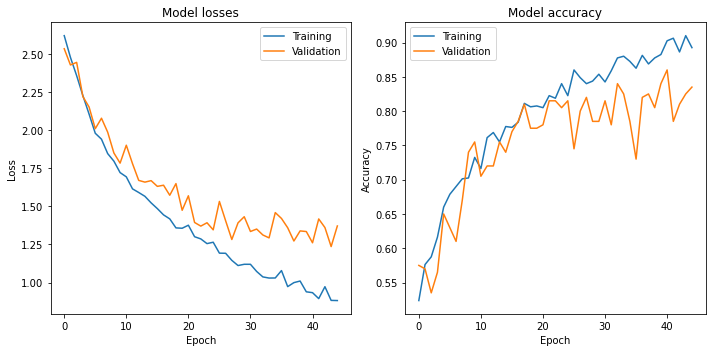

In [11]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model losses')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [344]:
100 * utils.evaluate_model(model, test_data, cuda=False, batch_size=20)

85.3

# without auxiliary loss

In [13]:
train_data, test_data = utils.read_input(normalize=True, pairs=1000, verbose=True)
epochs, lr, loss, optimizer, batch_size = 15, 0.01, 'cross_entropy', 'SGD', 20
model = ResNet(nb_residual_blocks = 10, nb_channels = 10, kernel_size = 5, nb_classes = 2)
train_loss, train_acc, val_loss, val_acc = utils.train_model(model, train_dataset=train_data, learning_rate=lr,
                                                             epochs=epochs, batch_size=batch_size, 
                                                             optimizer=optimizer, loss=loss, 
                                                             momentum=0.9, weight_decay=0.1, cuda=True)

train_input torch.Size([1000, 2, 14, 14]) train_target torch.Size([1000]) train_classes torch.Size([1000, 2])
test_input torch.Size([1000, 2, 14, 14]) test_target torch.Size([1000]) test_classes torch.Size([1000, 2])
normalize train and test datasets with train mean & std

Epoch: 1/15, Train Loss: 0.765473, Train Accuracy 52.250000% Val Loss: 0.680561, Val Accuracy: 52.999996%106/200

Epoch: 2/15, Train Loss: 0.710303, Train Accuracy 50.875000% Val Loss: 0.678490, Val Accuracy: 55.000000%110/200

Epoch: 3/15, Train Loss: 0.694427, Train Accuracy 53.125000% Val Loss: 0.665068, Val Accuracy: 57.000000%114/200

Epoch: 4/15, Train Loss: 0.657588, Train Accuracy 61.625000% Val Loss: 0.806506, Val Accuracy: 54.500000%109/200

Epoch: 5/15, Train Loss: 0.603704, Train Accuracy 67.625000% Val Loss: 1.078257, Val Accuracy: 52.000000%104/200

Epoch: 6/15, Train Loss: 0.549494, Train Accuracy 71.500000% Val Loss: 0.588954, Val Accuracy: 70.500000%141/200

Epoch: 7/15, Train Loss: 0.569964, Train A

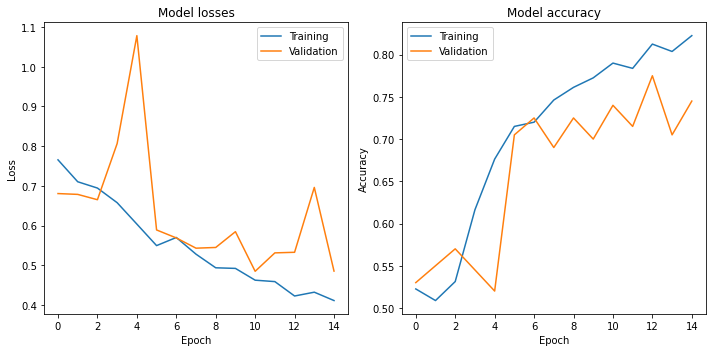

In [14]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model losses')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [15]:
print(100 * utils.evaluate_model(model, test_data, cuda=False, batch_size=20))

73.9
